In [1]:
import pandas as pd
import numpy as np
import os
import imageio
import datetime
import time
import sqlite3
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, roc_curve, auc, recall_score, f1_score, roc_auc_score


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import math
% matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

In [15]:
#load the loan data

loan = pd.read_csv('loan.csv')
loanT = pd.DataFrame.copy(loan)

/Volumes/Data/Anaconda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
loan_col = loan.columns.values

In [17]:
loan.shape

(887379, 74)

First let's clean up the data by doing feature engineering.

In [18]:
loan_useless = ['id', 'member_id','url', 'desc', 'verification_status']
loan.drop(loan_useless,axis=1,inplace = True)

In [19]:
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])
loan['issue_d'] = pd.to_datetime(loan['issue_d'])
loan['last_pymnt_d'] = pd.to_datetime(loan['last_pymnt_d'])
loan['next_pymnt_d'] = pd.to_datetime(loan['next_pymnt_d'])
loan['last_credit_pull_d'] = pd.to_datetime(loan['last_credit_pull_d'])
loan['dti_new'] = np.where(loan['application_type']=='JOINT', loan['dti_joint'],loan['dti'])
loan['annual_inc'] = np.where(loan['application_type']=='JOINT', loan['annual_inc_joint'],loan['annual_inc'])


In [20]:
loan['tot_cur_bal'].describe()

count    8.171030e+05
mean     1.394582e+05
std      1.537500e+05
min      0.000000e+00
25%      2.985300e+04
50%      8.055900e+04
75%      2.082050e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [21]:
loan['log_tot_cur_bal']= loan['tot_cur_bal'].apply([lambda x: math.log(x+1)])


In [22]:
loan['log_annual_inc'] = loan['annual_inc'].apply([lambda x: math.log(x)])


In [23]:
loan_col = loan.columns.values
loan_na = loan.isnull().sum()/len(loan)
for i in range(len(loan_na)):
    if loan_na[i]>=0.8:
        #print(loan_na[i], loan_col[i],i)
        loan.drop(loan_col[i], axis = 1, inplace = True)

In [24]:
loan_group = loan.groupby('term').size()
maj = loan_group[loan_group == loan_group.max()].index[0]

Missing value imputation, here for catalogical we use the most common one, and for numberica we use the mean

In [25]:
dt=loan.dtypes
dt.groupby(dt).size()

float64           35
datetime64[ns]     5
object            14
dtype: int64

In [175]:
#na inputation
for i in loan.columns.values:
    #print(i)
    if loan[i].dtypes == object or loan[i].dtypes == 'datetime64[ns]':
        loan_group = loan.groupby('term').size()
        maj = loan_group[loan_group == loan_group.max()].index[0]
        loan[i].fillna(maj, inplace = True)
    else:
        loan[i].fillna(loan[i].mean(skipna = True), inplace = True);

In [176]:
loan_col

array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open

In [177]:
loan.loc[loan['home_ownership'] =='ANY','home_ownership']  ='OTHER'
loan.loc[loan['home_ownership'] =='NONE','home_ownership']  ='OTHER'


In [178]:
loan['home_ownership'].value_counts()

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          235
Name: home_ownership, dtype: int64

In [179]:
df_timestamp = loan['issue_d'].copy()

In [180]:
dw= df_timestamp.apply(lambda x: x.dayofweek)

In [181]:
dw.value_counts()

2    159427
1    153699
6    146699
3    132357
5    121543
4     91175
0     82479
Name: issue_d, dtype: int64

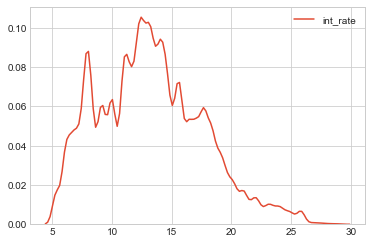

In [221]:
#The distribution of the int_rate looks like the following, it rages from 4 % to 30%
sns.kdeplot(loan['int_rate'])


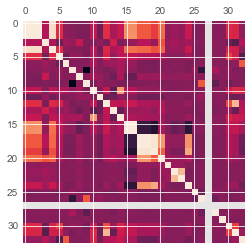

In [182]:
plt.matshow(loan.corr())

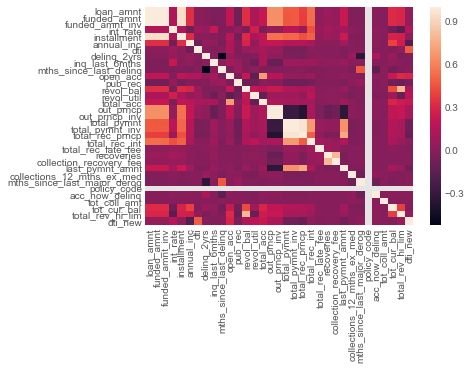

In [183]:
import seaborn as sns
corr = loan.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

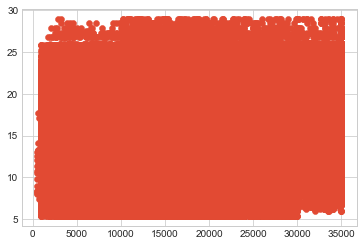

In [293]:
plt.scatter(loan['loan_amnt'],loan['int_rate'])

In [184]:
from scipy import stats

In [185]:
loan['term'].value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

Interesting Monday and Friday, less loans are taked out. 

In [382]:
int_36 = loan.loc[loan['term']==' 36 months', 'int_rate']
int_60 = loan.loc[loan['term']==' 60 months', 'int_rate']
t_test = stats.ttest_ind(int_36,int_60)
t_test.pvalue

0.0

In [187]:
import seaborn as sns
sns.set_style("whitegrid")


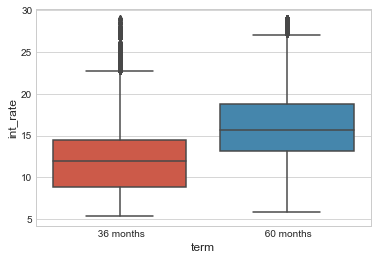

In [188]:
term_plot = sns.boxplot(x='term',y='int_rate',data = loan)

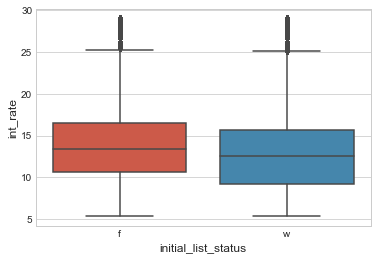

In [223]:
initial_list_plot = sns.boxplot(x='initial_list_status',y='int_rate',data = loan)

In [224]:
#t test
int_f = loan.loc[loan['initial_list_status']=='f', 'int_rate']
int_w = loan.loc[loan['initial_list_status']=='w', 'int_rate']
stats.ttest_ind(int_f,int_w)

Ttest_indResult(statistic=108.9911901720642, pvalue=0.0)

Both term and initial list status made a difference. 

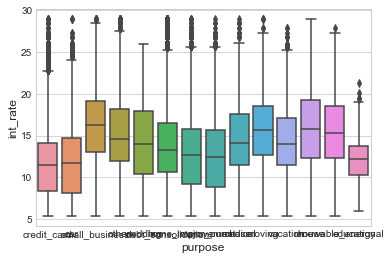

In [191]:
purpose_plot = sns.boxplot(x='purpose', y='int_rate', data = loan)

In [384]:
loan['purpose'].groupby(loan['grade']).sum()

grade
A    weddingmajor_purchasedebt_consolidationdebt_co...
B    credit_cardotherotherdebt_consolidationcredit_...
C    carsmall_businessotherdebt_consolidationdebt_c...
D    debt_consolidationotherotherdebt_consolidation...
E    cardebt_consolidationcredit_carddebt_consolida...
F    small_businesssmall_businessdebt_consolidation...
G    debt_consolidationdebt_consolidationothercredi...
Name: purpose, dtype: object

In [189]:
#one hot encoder
label_encoder = LabelEncoder()

In [190]:
integer_encoded = label_encoder.fit_transform(loan['purpose'])

In [80]:
onehot_encoder = OneHotEncoder(sparse = False)

In [81]:
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

In [82]:
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [84]:
onehot_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [94]:
loan['term'].describe()

count         887379
unique             2
top        36 months
freq          621125
Name: term, dtype: object

In [192]:
obj_loan = loan.select_dtypes(include = ['object']).copy()
obj_loan.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,36 months,10+ years,RENT,Fully Paid,n,credit_card,Computer,860xx,AZ,1985-01-01 00:00:00,f,2015-01-01 00:00:00,36 months,2016-01-01 00:00:00,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Charged Off,n,car,bike,309xx,GA,1999-04-01 00:00:00,f,2013-04-01 00:00:00,36 months,2013-09-01 00:00:00,INDIVIDUAL
2,36 months,C,C5,36 months,10+ years,RENT,Fully Paid,n,small_business,real estate business,606xx,IL,2001-11-01 00:00:00,f,2014-06-01 00:00:00,36 months,2016-01-01 00:00:00,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Fully Paid,n,other,personel,917xx,CA,1996-02-01 00:00:00,f,2015-01-01 00:00:00,36 months,2015-01-01 00:00:00,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Current,n,other,Personal,972xx,OR,1996-01-01 00:00:00,f,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-01-01 00:00:00,INDIVIDUAL


Now Let's start build some models. 

In [274]:
int_rate_sub=['int_rate', 'home_ownership', 'purpose','annual_inc', 'dti','term', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc','installment']

In [275]:
loan_int = loan[int_rate_sub]

In [276]:
loan_int.dtypes

int_rate          float64
home_ownership     object
purpose            object
annual_inc        float64
dti               float64
term               object
loan_amnt         float64
total_acc         float64
tot_cur_bal       float64
open_acc          float64
installment       float64
dtype: object

In [277]:
obj = ['home_ownership', 'purpose', 'term']

In [278]:
loan_int_encoded = pd.get_dummies(loan_int, prefix = obj, drop_first = True)

In [279]:
loan_int_encoded.columns.values

array(['int_rate', 'annual_inc', 'dti', 'loan_amnt', 'total_acc',
       'tot_cur_bal', 'open_acc', 'installment', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_ 60 months'], dtype=object)

In [377]:
y = loan_int_encoded['int_rate']
x = loan_int_encoded[[x for x in loan_int_encoded.columns.values if x != 'int_rate']]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)


In [378]:
from sklearn import preprocessing
X_train_scale = preprocessing.scale(X_train)
X_test_scale = preprocessing.scale(X_test)

In [379]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Many features are catogorical and in order to put them into linear regression we need to one hot encode them 

In [282]:
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [283]:
y_pred = clf.predict(X_test)

In [284]:
from sklearn.metrics import r2_score, f1_score, mean_squared_error
rss = sum((y_pred-y_test)**2)
print('Linear Regression r2: {0:.4f}, MSE: {0:.4f}, RSS:{0:.4f}'.format(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),rss))

Linear Regression r2: 0.5275, MSE: 0.5275, RSS:0.5275


Next we use lasso to regularize features

In [285]:
from sklearn.linear_model import Lasso

In [294]:

def lasso_regression(X_train, y_train, X_test, y_test, alpha, models_to_plot={}):
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(X_train, y_train)
    y_pred = lassoreg.predict(X_test)   
        #Return the result in pre-defined format
        
    rss = r2_score(y_test,y_pred)#sum((y_pred-y_test)**2)
    mse = mean_squared_error(y_test,y_pred)
    ret = [mse, rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret


In [295]:
alpha_lasso = [1e-8,1e-7, 1e-6,2*1e-6,1e-5,2*1e-5, 1e-4, 2*1e-4,1e-3,1e-2 ]

In [380]:
col = ['mse','r2','intercept'] + ['coef_x_%s'%i for i in X_train.columns.values if i != 'int_rate']
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(X_train_scale, y_train, X_test_scale, y_test, alpha_lasso[i])
    
    
    
    
    

In [381]:
coef_matrix_lasso


,mse,r2,intercept,coef_x_annual_inc,coef_x_dti,coef_x_loan_amnt,coef_x_total_acc,coef_x_tot_cur_bal,coef_x_open_acc,coef_x_installment,...,coef_x_purpose_house,coef_x_purpose_major_purchase,coef_x_purpose_medical,coef_x_purpose_moving,coef_x_purpose_other,coef_x_purpose_renewable_energy,coef_x_purpose_small_business,coef_x_purpose_vacation,coef_x_purpose_wedding,coef_x_term_ 60 months
alpha_1e-08,9.0415,0.529588,13.2458,-0.193195,0.157707,-12.961,-0.212651,-0.152375,0.0580092,12.2768,...,0.167336,0.0929361,0.243964,0.279803,0.545394,0.0806795,0.289882,0.223212,0.0959309,5.50822
alpha_1e-07,9.04146,0.52959,13.2458,-0.193203,0.157687,-12.9556,-0.212458,-0.152462,0.0577974,12.2719,...,0.166731,0.0916701,0.243063,0.279071,0.543524,0.0803891,0.288932,0.222506,0.0954248,5.50661
alpha_1e-06,9.04121,0.529603,13.2458,-0.193282,0.157478,-12.9009,-0.210527,-0.153333,0.0556801,12.2224,...,0.160673,0.0790107,0.234061,0.271747,0.524823,0.0774848,0.279434,0.215447,0.0903643,5.49062
alpha_2e-06,9.04133,0.529597,13.2458,-0.193368,0.157246,-12.8402,-0.208382,-0.1543,0.0533271,12.1674,...,0.153942,0.0649455,0.224058,0.26361,0.504045,0.0742578,0.26888,0.207604,0.0847417,5.47287
alpha_1e-05,9.0541,0.528933,13.2458,-0.194088,0.155359,-12.3584,-0.191134,-0.161942,0.0343909,11.7301,...,0.11481,-0.000176863,0.166175,0.216309,0.386576,0.0543236,0.208972,0.161508,0.0514341,5.33178
alpha_2e-05,9.08713,0.527214,13.2458,-0.194871,0.15255,-11.7593,-0.169926,-0.171273,0.0102914,11.1833,...,0.100211,-0.0124346,0.145398,0.198461,0.35329,0.0431049,0.191374,0.142589,0.0369417,5.15592
alpha_0.0001,10.1528,0.471771,13.2458,-0.194652,0.113987,-6.96474,-0.126684,-0.241896,-0,6.78501,...,0.0531405,-0,0.0826345,0.138855,0.315408,0,0.167718,0.0687892,0,3.74608
alpha_0.0002,13.4884,0.298222,13.2458,-0.195568,0.0647258,-0.964064,-0.0798771,-0.321752,-0,1.28273,...,0,-0,0.00481674,0.0648528,0.269042,0,0.138829,0,0,1.98411
alpha_0.001,16.3677,0.14842,13.2458,-0,0,0,-0,-0,-0,0,...,0,-0,0,0,0,0,0,0,0,1.05989
alpha_0.01,19.2204,-7.48123e-07,13.2458,-0,0,0,-0,-0,-0,0,...,0,-0,0,0,0,0,0,0,0,0


We see that starts from 1e-5, that coefficient starts to disappear 

Text(0,0.5,'parameter')

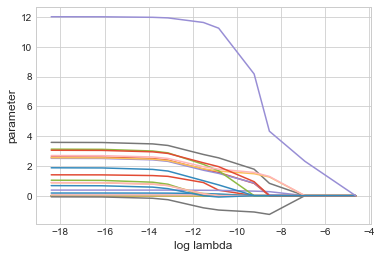

In [300]:
import math
log_lasso = [math.log(x) for x in alpha_lasso]
plt.plot(log_lasso, coef_matrix_lasso.drop(coef_matrix_lasso.columns[[0,1,2]],axis = 1))
plt.xlabel('log lambda')
plt.ylabel('parameter')


Text(0,0.5,'MSE')

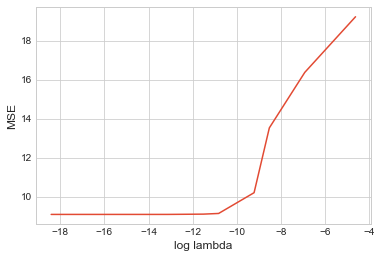

In [301]:
plt.plot(log_lasso, coef_matrix_lasso['mse'])
plt.xlabel('log lambda')
plt.ylabel('MSE')

In [291]:
# this shows the order when features are supress, bigger number means early supressed. 
(coef_matrix_lasso == 0).astype(int).sum().sort_values()

r2                                   0
intercept                            0
coef_x_term_ 60 months               1
coef_x_dti                           2
coef_x_purpose_small_business        2
coef_x_purpose_other                 2
coef_x_purpose_moving                2
coef_x_purpose_medical               2
coef_x_annual_inc                    2
coef_x_home_ownership_RENT           2
coef_x_purpose_credit_card           2
coef_x_installment                   2
coef_x_tot_cur_bal                   2
coef_x_total_acc                     2
coef_x_loan_amnt                     2
coef_x_purpose_house                 3
coef_x_purpose_vacation              3
coef_x_home_ownership_OTHER          4
coef_x_purpose_wedding               4
coef_x_purpose_major_purchase        4
coef_x_open_acc                      4
coef_x_purpose_renewable_energy      4
coef_x_home_ownership_OWN            4
coef_x_purpose_debt_consolidation    5
coef_x_purpose_home_improvement      5
coef_x_purpose_educationa

Here we learned that the most important features are term, dti, total_account, total current balance, purpose, home ownership, installment, annual income and loan amount. 

In [273]:
#Final Lasso
lassoreg = Lasso(alpha=0.0001,normalize=True, max_iter=1e5)
lassoreg.fit(X_train, y_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [349]:
#log int rate
loan['log_int_rate']= loan['int_rate'].apply([lambda x: math.log(x)])
log_int_rate_sub=['log_int_rate', 'home_ownership', 'purpose','annual_inc', 'dti','term', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc','installment']

y = loan['log_int_rate']
x = loan_int_encoded[[x for x in loan_int_encoded.columns.values if x != 'int_rate']]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)






In [351]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [352]:
rss = sum((y_pred-y_test)**2)
print('Linear Regression r2: {0:.4f}, MSE: {0:.4f}, RSS:{0:.4f}'.format(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),rss))

Linear Regression r2: 0.4844, MSE: 0.4844, RSS:0.4844


In [363]:
#log annual income, currentl tot balance 
int_rate_sub=['log_int_rate', 'home_ownership', 'purpose','log_annual_inc', 'dti','term', 'loan_amnt', 'total_acc', 'log_tot_cur_bal', 'open_acc','installment']
loan_logint = loan[int_rate_sub]
loan_logint_encoded = pd.get_dummies(loan_logint, prefix = obj, drop_first = True)


In [365]:
y = loan['log_int_rate']

x = loan_logint_encoded[[x for x in loan_logint_encoded.columns.values if x != 'log_int_rate']]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)


In [366]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rss = sum((y_pred-y_test)**2)
print('Linear Regression r2: {0:.4f}, MSE: {0:.4f}, RSS:{0:.4f}'.format(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),rss))

Linear Regression r2: 0.4965, MSE: 0.4965, RSS:0.4965


## Predicting Grade 

In [368]:
#logistic regression


Grade_sub = loan_logint_encoded[[x for x in loan_logint_encoded.columns.values if x != 'log_int_rate']]
y = loan['grade']
x = Grade_sub
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)


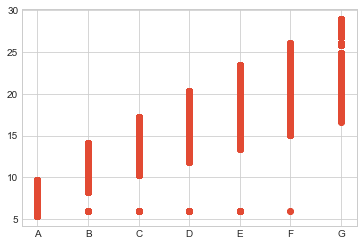

In [369]:
plt.scatter(loan['grade'],loan['int_rate'])

In [312]:
loan['grade'].value_counts()

B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64

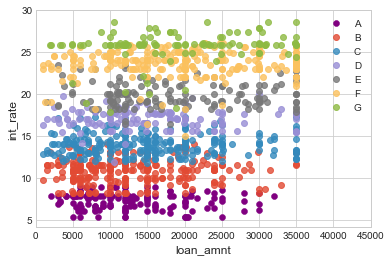

In [321]:
plt.scatter(loan[loan['grade']=='A']['loan_amnt'][::1000], loan[loan['grade']=='A']['int_rate'][::1000],label='A',c='purple')
sns.regplot(loan[loan['grade']=='B']['loan_amnt'][::1000], loan[loan['grade']=='B']['int_rate'][::1000],label = 'B',fit_reg=False)
sns.regplot(loan[loan['grade']=='C']['loan_amnt'][::1000], loan[loan['grade']=='C']['int_rate'][::1000],label = 'C',fit_reg=False)
sns.regplot(loan[loan['grade']=='D']['loan_amnt'][::1000], loan[loan['grade']=='D']['int_rate'][::1000],label = 'D',fit_reg=False)
sns.regplot(loan[loan['grade']=='E']['loan_amnt'][::500], loan[loan['grade']=='E']['int_rate'][::500],label = 'E',fit_reg=False)
sns.regplot(loan[loan['grade']=='F']['loan_amnt'][::100], loan[loan['grade']=='F']['int_rate'][::100],label = 'F',fit_reg=False)
sns.regplot(loan[loan['grade']=='G']['loan_amnt'][::50], loan[loan['grade']=='G']['int_rate'][::50],label = 'G',fit_reg=False)
plt.xlim(0,45000)
plt.legend()





There is a Strong correlation between grade and interst rate, so predicting the grade can also be a good metrics

In [370]:
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

/Volumes/Data/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [371]:
y_pred = clf.predict(X_test)

In [372]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.4758141945953256

# On the bank side I would like to predice weather a loan will charge off


In [143]:
loan['loan_status'].describe()

count      887379
unique         10
top       Current
freq       601779
Name: loan_status, dtype: object

In [144]:
loan['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [156]:
Pred_loan_status['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [388]:
Pred_loan_status=loan[(loan['loan_status'] != 'Current') & (loan['loan_status'] != 'Issued')]

In [389]:
Pred_loan_status.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,dti_new,log_int_rate,log_annual_inc,log_tot_cur_bal
count,277140.000000,277140.000000,277140.000000,277140.000000,277140.000000,2.771400e+05,277140.000000,277140.000000,277140.000000,277140.000000,...,277140.000000,277140.0,277140.000000,2.771400e+05,2.771400e+05,2.771400e+05,277140.000000,277140.000000,277140.000000,277140.000000
mean,13682.046799,13642.893934,13531.736104,13.924880,420.922943,7.248485e+04,16.760824,0.263391,0.883460,34.384491,...,43.966474,1.0,0.003432,2.103215e+02,1.375006e+05,3.006910e+04,16.760323,2.580047,11.045323,11.341488
std,8184.154070,8164.265903,8198.750431,4.419136,245.984493,6.068772e+04,7.885771,0.768766,1.151946,14.711039,...,9.580295,0.0,0.063507,1.744567e+04,1.319793e+05,2.569644e+04,7.884544,0.335934,0.521802,1.148948
min,500.000000,500.000000,0.000000,5.320000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.671473,7.547502,0.000000
25%,7500.000000,7475.000000,7200.000000,10.990000,242.570000,4.500000e+04,10.900000,0.000000,0.000000,34.063798,...,44.104838,1.0,0.000000,0.000000e+00,3.763650e+04,1.570000e+04,10.900000,2.396986,10.714418,10.535756
50%,12000.000000,12000.000000,12000.000000,13.670000,367.410000,6.200000e+04,16.420000,0.000000,1.000000,34.063798,...,44.104838,1.0,0.000000,0.000000e+00,1.394582e+05,2.990000e+04,16.420000,2.615204,11.034890,11.845527
75%,18775.000000,18500.000000,18250.000000,16.890000,550.220000,8.700000e+04,22.270000,0.000000,1.000000,34.063798,...,44.104838,1.0,0.000000,2.257026e+02,1.648988e+05,3.206862e+04,22.270000,2.826722,11.373663,12.013093
max,35000.000000,35000.000000,35000.000000,28.990000,1424.570000,8.900060e+06,59.260000,29.000000,33.000000,152.000000,...,159.000000,1.0,5.000000,9.152545e+06,8.000078e+06,2.013133e+06,39.990000,3.366951,16.001569,15.894962


In [448]:
info_leak_col = ['emp_title','issue_d','title', 'zip_code', 'addr_state','out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d','collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code','tot_coll_amt','emp_length','earliest_cr_line']

In [426]:
(loan['earliest_cr_line'][0]-datetime.now()).days

AttributeError: 'int' object has no attribute 'astype'

In [425]:
((loan['earliest_cr_line'][0]-datetime.now()).days / np.timedelta64(1, 'D')).astype(int)

TypeError: ufunc true_divide cannot use operands with types dtype('int64') and dtype('<m8[D]')

In [430]:
from datetime import timedelta, datetime
today = datetime.now()
loan['cre_len']=loan['earliest_cr_line'].apply(lambda x: (today - x).days)

In [429]:
loan['earliest_cr_line']= pd.to_datetime(loanT['earliest_cr_line'])

In [435]:
Investor_lend = loan.copy()

In [449]:
Investor_lend.drop(info_leak_col,axis = 1,inplace = True)

In [450]:
Investor_lend['loan_status'].value_counts()

Fully Paid     207723
Charged Off     69417
Name: loan_status, dtype: int64

In [442]:
Investor_lend=Investor_lend[(Investor_lend['loan_status'] != 'Current') & (Investor_lend['loan_status'] != 'Issued')]

In [443]:
Investor_lend.loc[Investor_lend['loan_status'] != 'Fully Paid', 'loan_status'] = 'Charged Off'

In [ ]:
Investor_lend

In [447]:
Investor_lend.dtypes

loan_amnt                             float64
funded_amnt                           float64
funded_amnt_inv                       float64
term                                   object
int_rate                              float64
installment                           float64
grade                                  object
sub_grade                              object
emp_title                              object
emp_length                             object
home_ownership                         object
annual_inc                            float64
issue_d                        datetime64[ns]
loan_status                            object
pymnt_plan                             object
purpose                                object
title                                  object
zip_code                               object
addr_state                             object
dti                                   float64
delinq_2yrs                           float64
earliest_cr_line               dat

In [445]:
obj = ['loan_status','home_ownership', 'purpose', 'term','grade','sub_grade','pymnt_plan','initial_list_status','application_type']

In [451]:
Investor_lend_encoded = pd.get_dummies(Investor_lend, prefix = obj, drop_first = True)

In [453]:
Investor_lend_encoded.columns.values

array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq',
       'tot_cur_bal', 'total_rev_hi_lim', 'dti_new', 'log_int_rate',
       'log_annual_inc', 'log_tot_cur_bal', 'cre_len',
       'loan_status_ 60 months', 'home_ownership_B', 'home_ownership_C',
       'home_ownership_D', 'home_ownership_E', 'home_ownership_F',
       'home_ownership_G', 'purpose_A2', 'purpose_A3', 'purpose_A4',
       'purpose_A5', 'purpose_B1', 'purpose_B2', 'purpose_B3',
       'purpose_B4', 'purpose_B5', 'purpose_C1', 'purpose_C2',
       'purpose_C3', 'purpose_C4', 'purpose_C5', 'purpose_D1',
       'purpose_D2', 'purpose_D3', 'purpose_D4', 'purpose_D5',
       'purpose_E1', 'purpose_E2', 'purpose_E3', 'purpose_E4',
       'purpose_E5', 'purpose_F1', 'purpose_F2', 'purpose_F3',
       'purpose_F4', 'purp